In [2]:
import numpy as np
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset 
import torchvision.transforms as transforms
from torchmetrics import ConfusionMatrix
import seaborn as sns
import torchvision.models as models
from PIL import Image, ImageDraw, ImageFont
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\T480S\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from google.colab import files
uploaded = files.upload()
import zipfile

with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,], std=[0.5,]),
        ]
    )
train_dataset = datasets.ImageFolder(
    root= r'C:\Users\T480S\Machine Learning\emotion_recognition\archive\fer2013plus\fer2013\train',
    transform=transform
)
test_data = datasets.ImageFolder(
    root= r'C:\Users\T480S\Machine Learning\emotion_recognition\archive\fer2013plus\fer2013\test',
    transform=transform
)
torch.manual_seed(42)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size],generator=torch.Generator().manual_seed(42))
train_loader = DataLoader( train_data, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader( val_data, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader( test_data, batch_size=64, shuffle=False, num_workers=2)

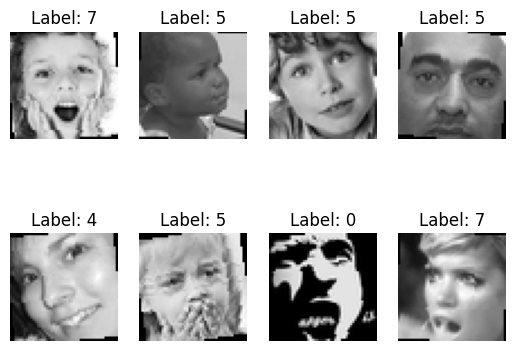

In [3]:
def visualize_samples(loader):
    examples = iter(loader)
    example_data, example_targets = next(examples) #.next()

    for i in range(8):
        plt.subplot(2, 4, i+1)
        # image = example_data[i]
        # image = image.permute(1, 2, 0)  
        # image = image * 0.5 + 0.5
        plt.imshow(torch.transpose(example_data[i][0],1,0),cmap='gray')
        plt.imshow(example_data[i][0],cmap='gray')
        plt.title(f'Label: {example_targets[i].item()}')
        plt.axis('off')
    plt.show()

visualize_samples(train_loader)

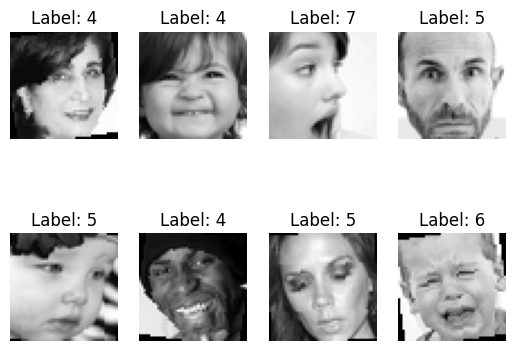

In [4]:
visualize_samples(val_loader)

In [4]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN,self).__init__()
        self.c1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1) 
        #output size = input_size - kernel_size + 2*padding + 1
        #output size = 48 - 3 + 2*1 + 1 = 48
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        #output size = 48/2 = 24
        self.c2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1) 
        #output size = 24 - 3 + 2*1 + 1 = 24
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        #output size = 24/2 = 12
        self.c3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        #output size = 12 - 3 + 2*1 + 1 = 12
        self.bn3= nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()  
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        #output size = 12/2 = 6
        self.c4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        #output size = 6 - 3 + 2*1 + 1 = 6
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=2)
        #output size = 6/2 = 3
        self.c5 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        #output size = 3 - 3 + 2*1 + 1 = 3
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2,stride=2)
        #output size = 3/2 = 1

        self.l1 = nn.Linear(512*1*1, 1024)
        self.relu6 = nn.ReLU()
        self.l2 = nn.Linear(1024,8)
    def forward(self,x):
        x = self.c1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.c2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x= self.c3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.c4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = self.c5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool5(x)   

        #x = x.view(-1,128*7*7)
        x=x.view(x.size(0), -1) 
        x = self.l1(x)
        x = self.relu6(x)
        x = self.l2(x)
        return x



In [5]:
model = myCNN().to(device)
model.load_state_dict(torch.load('emotion_recognition.pth'))
model.eval()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer.load_state_dict(torch.load('optimizer.pth'))
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

In [ ]:
# model = models.resnet18(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

# for param in model.fc.parameters():
#     param.requires_grad = True

# model.fc = nn.Linear(in_features=512, out_features=7, bias=True)
# model.load_state_dict(torch.load('emotion_recognition.pth'))
# model.train()

# loss_function = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer.load_state_dict(torch.load('optimizer.pth'))
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2)

c:\Users\T480S\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\T480S\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def train_model(model,optim,loss_function,train_loader,val_loader,num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_no, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_loss /= len(train_loader)
        #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()

            val_loss /= len(val_loader.dataset)
            val_accuracy = 100 * correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {running_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
        #scheduler.step(val_loss)
        #print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")  

train_model(model, optimizer, loss_function, train_loader,val_loader, num_epochs=20)

Epoch 1/20 | Train Loss: 0.0023 | Val Loss: 0.9980 | Val Acc: 65.08%
Epoch 2/20 | Train Loss: 0.0027 | Val Loss: 0.8711 | Val Acc: 69.57%
Epoch 3/20 | Train Loss: 0.0027 | Val Loss: 0.8610 | Val Acc: 69.23%
Epoch 4/20 | Train Loss: 0.0027 | Val Loss: 0.7724 | Val Acc: 72.26%
Epoch 5/20 | Train Loss: 0.0026 | Val Loss: 0.7787 | Val Acc: 70.69%
Epoch 6/20 | Train Loss: 0.0023 | Val Loss: 0.7543 | Val Acc: 74.15%
Epoch 7/20 | Train Loss: 0.0012 | Val Loss: 0.7093 | Val Acc: 75.22%
Epoch 8/20 | Train Loss: 0.0019 | Val Loss: 0.6857 | Val Acc: 76.15%
Epoch 9/20 | Train Loss: 0.0017 | Val Loss: 0.6930 | Val Acc: 75.75%
Epoch 10/20 | Train Loss: 0.0019 | Val Loss: 0.6895 | Val Acc: 76.15%
Epoch 11/20 | Train Loss: 0.0019 | Val Loss: 0.6929 | Val Acc: 76.72%
Epoch 12/20 | Train Loss: 0.0012 | Val Loss: 0.7054 | Val Acc: 76.05%
Epoch 13/20 | Train Loss: 0.0012 | Val Loss: 0.7054 | Val Acc: 75.80%
Epoch 14/20 | Train Loss: 0.0012 | Val Loss: 0.7633 | Val Acc: 74.50%
Epoch 15/20 | Train Loss: 0.0

In [8]:
torch.save(model.state_dict(),'./emotion_recognition.pth')
torch.save(optimizer.state_dict(), './optimizer.pth')

Accuracy of the model on the test set: 76.00%


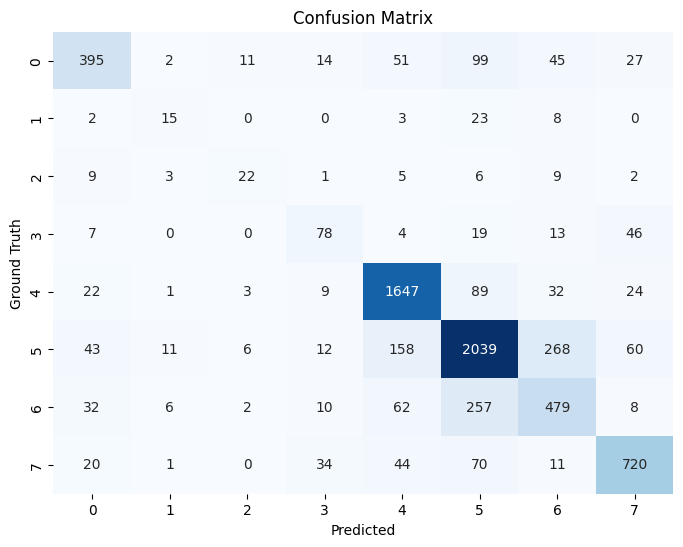

In [9]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    pred = []
    true = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred.append(predicted)
            true.append(labels)

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

    confmat = ConfusionMatrix(task="multiclass", num_classes=8)
    conf_matrix = confmat(torch.cat(pred,dim=0), torch.cat(true,dim=0))

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=[f'{i}' for i in range(8)],
                yticklabels=[f'{i}' for i in range(8)])
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_loader)

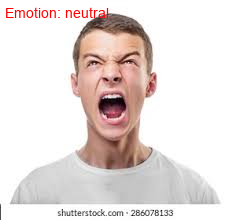

In [98]:
class_names = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness','surprise']
transform2 = transforms.Compose(
    [
        transforms.Resize((48, 48)),  
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,], std=[0.5,]),
    ]   
)
def predict_and_draw(image_path):
    # Load original image (colored or grayscale)
    original_image = Image.open(image_path).convert('RGB')  # to keep it colorful for text
    img_tensor = transform2(original_image).unsqueeze(0)

    # Predict
    with torch.no_grad():
        output = model(img_tensor)
        predicted_idx = torch.argmax(output, dim=1).item()
        predicted_label = class_names[predicted_idx]

    # Draw emotion text on the image
    draw = ImageDraw.Draw(original_image)
    
    # Optional font setup (system font may not be found; fallback works)
    try:
        font = ImageFont.truetype("arial.ttf", 14)
    except:
        font = ImageFont.load_default()

    text = f"Emotion: {predicted_label}"
    draw.text((5, 5), text, fill='red', font=font)



    return original_image  # in case you want to save or process it

# Step 6: Run the function on your image
predict_and_draw(r'C:\\Users\\T480S\\Machine Learning\\test.jpeg')  # Replace with any image path